In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and Preprocessing

In [4]:
# Keep only needed columns
feature_names = [
    "Age", "Workclass", "Education", 
    "Occupation", "Relationship", "Race", 
    "Sex", "Capital Gain", "Capital Loss", 
    "Hours per week", "Country", "label"
]

df = pd.DataFrame(
  np.genfromtxt('dataset/adult.csv', delimiter=', ', dtype=str, usecols=(0,1,3,6,7,8,9,10,11,12,13,14)),    
  columns=feature_names
)

# Drop missing values denoted as ?
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()


# Declare categorical columns
categorical_columns=[
   "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Country", "label"
]

# Assign type to features
for feature in feature_names:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        df[feature] = df[feature].astype("int")

# Make bins for age and hours per week
df['Age'] = pd.cut(df['Age'], bins=[16, 35 , 90],labels=['Young','Aged'])
df["Hours per week"] = pd.cut(
            x=df["Hours per week"],
            bins=[0.9, 25, 39, 40, 55, 100],
            labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"])

# Replace "Husband" and "Wife" values with the unisex "Married"
df["Relationship"] = df["Relationship"].replace('Husband','Married')
df["Relationship"] = df["Relationship"].replace('Wife','Married')

# Will have income >50k (1 or 0)
df["label"] = df["label"].replace('>50K',1)
df["label"] = df["label"].replace('<=50K',0)

df.sample(5)

C:\Users\stef4\AppData\Local\Temp\ipykernel_14284\1809994134.py:40: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Relationship"] = df["Relationship"].replace('Husband','Married')
C:\Users\stef4\AppData\Local\Temp\ipykernel_14284\1809994134.py:41: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Relationship"] = df["Relationship"].replace('Wife','Married')
C:\Users\stef4\AppData\Local\Temp\ipykernel_14284\1809994134.py:44: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace wil

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
22255,Young,Private,HS-grad,Adm-clerical,Not-in-family,White,Female,0,0,OverTime,United-States,0
24104,Aged,Private,HS-grad,Craft-repair,Married,White,Male,0,0,OverTime,United-States,1
15479,Aged,Private,9th,Other-service,Unmarried,Black,Female,0,0,FullTime,United-States,0
13704,Aged,Private,11th,Farming-fishing,Married,White,Male,0,0,OverTime,United-States,0
12508,Aged,Self-emp-inc,Some-college,Exec-managerial,Married,White,Male,0,0,BrainDrain,United-States,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             30162 non-null  category
 1   Workclass       30162 non-null  category
 2   Education       30162 non-null  category
 3   Occupation      30162 non-null  category
 4   Relationship    30162 non-null  category
 5   Race            30162 non-null  category
 6   Sex             30162 non-null  category
 7   Capital Gain    30162 non-null  int32   
 8   Capital Loss    30162 non-null  int32   
 9   Hours per week  30162 non-null  category
 10  Country         30162 non-null  category
 11  label           30162 non-null  category
dtypes: category(10), int32(2)
memory usage: 769.9 KB


## Model Creation

In [7]:
# Data preprocessing to train model
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

tabular_data = Tabular(
   df,
   categorical_columns=[
  "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
],
   target_column='label'
)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

# Split data into training and (validation + test) datasets
train, X_temp, train_labels, y_temp  = \
    train_test_split(x[:, :-1], x[:, -1], train_size=0.70, random_state = 123)

# Split data validation and test sets
val, test, val_labels, test_labels = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

test_labels = test_labels.astype(int)

print('Training data shape:   {}'.format(train.shape))
print('Validation data shape:  {}'.format(val.shape))
print('Test data shape:        {}'.format(test.shape))

# Train a Random Forest model
model = RandomForestClassifier(random_state=123)
model.fit(train, train_labels)

predict_function=lambda z: model.predict_proba(transformer.transform(z))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

display(tabular_data.target_column)
display(train_labels[:2])

Training data shape:   (21113, 99)
Validation data shape:  (4524, 99)
Test data shape:        (4525, 99)


'label'

array([1., 0.])

In [8]:
# Model Predictions
test_df = test_data.to_pd()
test_df["label"] = test_labels
predictions = model.predict(test)
test_df["prediction"] = predictions

test_df.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label,prediction
3624,Aged,State-gov,Bachelors,Exec-managerial,Married,White,Male,0.0,0.0,FullTime,United-States,1,1.0
304,Aged,Private,Bachelors,Prof-specialty,Unmarried,White,Female,0.0,0.0,MidTime,United-States,0,0.0
4243,Aged,Private,Some-college,Transport-moving,Not-in-family,White,Male,0.0,0.0,FullTime,United-States,0,0.0
2046,Aged,Local-gov,Masters,Exec-managerial,Married,Black,Male,0.0,1977.0,OverTime,United-States,1,1.0
3462,Aged,Private,7th-8th,Transport-moving,Married,White,Male,0.0,0.0,FullTime,United-States,0,0.0


Test: accuracy=0.8513
Test: TP=734, TN=3118, FP=263, FN=410


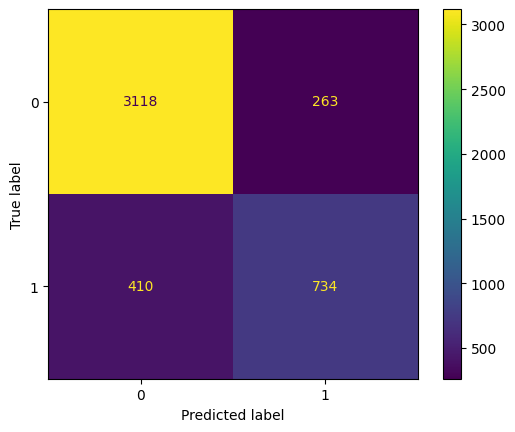

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(test_labels, predictions)
print(f'Test: {accuracy=:.4f}')

cm = confusion_matrix(test_labels, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()

## Fairness
Now the fairness will be analyzed

First we import the necessary libraries

In [11]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
import random
from aif360.metrics import ClassificationMetric

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Since for the fairness analysis, we can not use the Tabular data, we create a new dataframe with the transformed values of TabularTransform. This is because we need to have access to a dataframe structure containing the binarized values (for age, sex and all categorical attributes) and not the categorical values (e.g. Young/Aged, Female/Male etc.)

In [13]:
column_names = transformer.get_feature_names()
# Last column is the label which is not included in the get_feature_names
column_names.append('label')

fairness_dataset = pd.DataFrame(x, columns=column_names)
fairness_dataset.head(3)

,Age_Aged,Age_Young,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_10th,...,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia,Capital Gain,Capital Loss,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2174.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


As seen below there are four columns for the protected attributes of sex and age. Two boolean columns for each:

In [15]:
fairness_dataset[['Age_Aged', 'Age_Young', 'Sex_Male', 'Sex_Female']].head(3)

,Age_Aged,Age_Young,Sex_Male,Sex_Female
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0


We decide only to keep `Age_Aged` and `Sex_Male`, and renaming those to columns to `Age` and `Sex` meaning that:
- when `Sex` is 0, the person is female and when when `Sex` is 1, the person is male
- when `Age` is 0, the person is young and  when `Age` is 0, the person is aged


In [17]:
fairness_dataset = fairness_dataset.drop(columns=['Age_Young', 'Sex_Female'])
fairness_dataset.rename(columns={'Age_Aged': 'Age', 'Sex_Male': 'Sex'}, inplace=True)

Next we want to ensure that we train the classifier on the exact same data as the previous normal classifier, keeping the train, validation and test split:

In [19]:
# Split data into training and (validation + test) datasets
train, X_temp, _, y_temp  = \
    train_test_split(fairness_dataset, fairness_dataset.label, train_size=0.70, random_state = 123)

# Split data validation and test sets
val, test, _, _ = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

Now we can transform the previous data structures into BinaryLabelDatasets:

In [21]:
# Transform to BinaryLabelDataset
dataset_fair_train = BinaryLabelDataset(df=train, label_names=['label'], protected_attribute_names=['Age', 'Sex'])
dataset_fair_valid = BinaryLabelDataset(df=val, label_names=['label'], protected_attribute_names=['Age', 'Sex'])
dataset_fair_test = BinaryLabelDataset(df=test, label_names=['label'], protected_attribute_names=['Age', 'Sex'])

Now the group fairness of the classifier will be assessed, assuming the protected attributes are Age, Sex.

We assume that:
- Young age (corresponding to 0) is one unprivileged group and Aged (corresponding to 1) is one privileged group
- Female sex is one unprivileged (corresponding to 0) group and male sex (corresponding to 1) is one privileged group:

In [23]:
privileged_groups = [{'Age':1,
                      'Sex':1}]
unprivileged_groups = [{'Age': 0,
                       'Sex':0}]

Since there is a significant difference in the positive rates and true positive rate thus there is unfairness. Actually, the priviliged groups (aged and male) has 37% more chance to be predicted as >50k income comparing to the unprivileged group (young, female)

Now, we will try to mitigate this bias in the training dataset by using the `Reweighing algorithm`. By reweighing we ensure that there is better fairness when we compare the positive rates between privileged and unprivileged groups

In [25]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_fair_train)

### Fair classifier

Since reweighting does not achieve the goal of $0$ statistical parity difference or Equal opportunity difference, we will oversample the underprivileged classes (female young) and undersample the privileged classes (male aged) to teach the classifier to be more fair. After some experimentation, it was decided:
- $750$ extra samples of young female with income >50k were randomly oversampled in the training data, and random weights of values between $[1.2,1.6]$ were given for each sample
- $1500$ samples of aged male with income >50k were randomly undersampled in the training data (completely removed from the training set)

In [27]:
# Seed to reproduce results
random.seed(1)

# Number of over-samples produced for training dataset
number_oversamples = 750
# Number of under-samples to be removed for training dataset
number_undersamples = 1500

# Train and target data
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

# Resampled data structures
X_train_resampled = X_train.copy()
y_train_resampled = y_train.copy()
weights_resampled = dataset_transf_train.instance_weights.copy()

# list to keep for indexes of undersamples (to be deleted after)
list_indexes_undersamples = []
# List to keep the over_samples and counters of oversamples and undersamples
oversamples = []
counter_oversamples = 0
counter_undersamples = 0

# Iterate over the whole training dataset
for counter in range(len(X_train)):
    # Only append rows that contain young female since this is the heavily underprivileged class
    if (X_train[counter][0] == 0) and (X_train[counter][1] == 0) and (y_train[counter] == 1)\
        and (counter_oversamples < number_oversamples):
        oversamples.append(X_train[counter].copy())
        counter_oversamples += 1
    # Store index of rows that contain aged male since this is the heavily overprivileged class
    if ((X_train[counter][0] == 1) or (X_train[counter][1] == 1)) and (y_train[counter] == 1)\
        and (counter_undersamples < number_undersamples):
        list_indexes_undersamples.append(counter)
        counter_undersamples += 1
    # When number of extra oversamples and undersamples is reached, stop loop
    if (counter_oversamples == number_oversamples) and (counter_undersamples == number_undersamples):
        break
    counter += 1

# Remove all indexes of undersamples
X_train_resampled = np.delete(X_train_resampled, list_indexes_undersamples, axis=0)
y_train_resampled = np.delete(y_train_resampled, list_indexes_undersamples)
weights_resampled = np.delete(weights_resampled, list_indexes_undersamples)


# Only assign positive labels to favor underprivileged class 
arr = np.array([1 for i in range(number_oversamples)])

# Append extra samples and labels to the training data and 
y_train_resampled = np.append(y_train_resampled, arr)
X_train_resampled = np.vstack([X_train_resampled, oversamples])
# Randomize weights of extra samples to take values between 1 and 1.5
weights_resampled = np.append(weights_resampled, np.array([random.uniform(1.2, 1.6) for i in range(number_oversamples)]))

Now we can train the classifier:

In [29]:
model_fair_reweighted = RandomForestClassifier(random_state=123)
model_fair_reweighted.fit(X_train_resampled, y_train_resampled, sample_weight=weights_resampled)

X_test = dataset_fair_test.features
y_test = dataset_fair_test.labels

Next predict the test data <b> based on the threshold </b> found in the fairness analysis:

In [31]:
predictions = []
threshold_fairness = 0.2080
# positive class index
pos_ind = 1

for item in model_fair_reweighted.predict_proba(X_test)[:,pos_ind].reshape(-1,1):
    if item >=  threshold_fairness:
        predictions.append(1)
    else:
        predictions.append(0)

Last let's print the metrics for this classifier:

Test: accuracy=0.7929
Test: TP=886, TN=2702, FP=679, FN=258


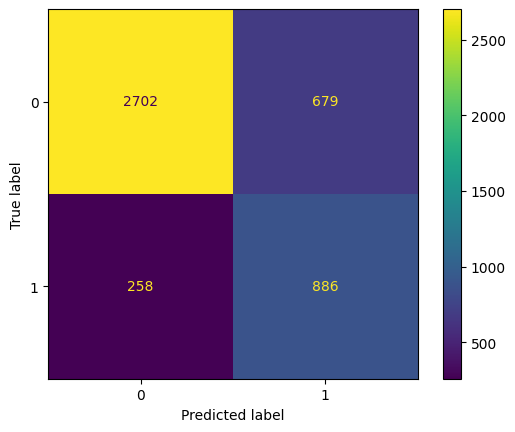

In [33]:
accuracy = accuracy_score(y_test, predictions)
print(f'Test: {accuracy=:.4f}')

cm = confusion_matrix(y_test, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()

Also the fairness metric of `equal opportunity difference` will be printed for the fair classifier:

In [35]:
# Preparation of predictions dateset - transform into BinaryLabelDataset with right predictions based on the fairness threshold
dataset_fair_test_pred = dataset_fair_test.copy(deepcopy=True)
dataset_fair_test_pred.scores = model_fair_reweighted.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
fav_inds = dataset_fair_test_pred.scores > threshold_fairness
dataset_fair_test_pred.labels[fav_inds] = dataset_fair_test_pred.favorable_label
dataset_fair_test_pred.labels[~fav_inds] = dataset_fair_test_pred.unfavorable_label

# Calculate metric
equal_opportunity_diff_metric = ClassificationMetric(dataset_fair_test, dataset_fair_test_pred, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups).equal_opportunity_difference()
print(f'Equal opportunity difference: {equal_opportunity_diff_metric=:.4f}')

Equal opportunity difference: equal_opportunity_diff_metric=-0.0141


## Privacy

In [ ]:
# Helper Functions for local differential privacy

import random
import math

# randomized response 
def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

def estimate(column, p=0.75, q=0.75):
    n_people = len(column)
    n_reported = np.sum(column.astype(int))
    return (n_reported/n_people + q - 1)/(p+q-1)*n_people

# apply attribute to a attribute
def privatize_attribute(column, true_label, false_label, p, q):
    # Convert labels to binary values
    binary_values = column.apply(lambda x: 1 if x == true_label else 0).values
    
    # Apply randomized response
    privatized_values = pd.Series([rand_resp(x, p, q) for x in binary_values])

    # Convert back to original labels
    return privatized_values.apply(lambda x: true_label if x == 1 else false_label)

def get_epsilon(p=0.75, q=0.75):
    return math.log( max(q/(1-p), p/(1-q)) )

def get_p_q(epsilon):
    p = math.exp(epsilon)/(1+math.exp(epsilon))
    return p, p

In [ ]:
# Create a copy of the original data
df_private = df.copy(deep=True)

# Set values of p and q
p_age, q_age = 0.9, 0.9
p_sex, q_sex = 0.9, 0.9  

epsilon_age = get_epsilon(p_age, q_age)
epsilon_sex = get_epsilon(p_sex, q_sex)
print(f"We will apply {epsilon_age:.3f}-LDP setting p={p_age}, q={q_age} for age \
AND {epsilon_sex:.3f}-LDP setting p={p_sex}, q={q_sex} for sex.")

# Apply randomized response to Age and Sex
df_private['Age'] = privatize_attribute(df_private['Age'], 'Aged', 'Young', p_age, q_age)
df_private['Sex'] = privatize_attribute(df_private['Sex'], 'Male', 'Female', p_sex, q_sex)

# Display the new DataFrame
df_private.head()

In [ ]:
# Showing cross tabulation
print("\nOriginal Cross-tabulation:")
print(pd.crosstab(df['Age'], df['Sex']))

print("\nPrivatized Cross-tabulation:")
print(pd.crosstab(df_private['Age'], df_private['Sex']))

In [ ]:
# Quantify the Error    

In [ ]:
# Implement Private Classifier

tabular_data_private = Tabular(
   df_private,
   categorical_columns=[
  "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
],
   target_column='label'
)
transformer_private = TabularTransform().fit(tabular_data_private)
class_names = transformer_private.class_names
x_private = transformer_private.transform(tabular_data_private)

# Split data into training and (validation + test) datasets
train_private, X_private_temp, train_labels_private, y_private_temp  = \
    train_test_split(x_private[:, :-1], x_private[:, -1], train_size=0.70, random_state = 123)

# Split data validation and test sets
val_private, test_private, val_labels_private, test_labels_private = train_test_split(X_private_temp, y_private_temp, test_size=0.5, random_state=123)

test_labels_private = test_labels_private.astype(int)

print('Private Classfier')
print('Training data shape:   {}'.format(train_private.shape))
print('Validation data shape:  {}'.format(val_private.shape))
print('Test data shape:        {}'.format(test_private.shape))

# Train a Random Forest model
model_private = RandomForestClassifier(random_state=123)
model_private.fit(train_private, train_labels_private)

predict_function_private=lambda z: model_private.predict_proba(transformer_private.transform(z))

# # Convert the transformed data back to Tabular instances
train_data_private = transformer_private.invert(train_private)
test_data_private = transformer_private.invert(test_private)

display(tabular_data_private.target_column)
display(train_labels_private[:2])

In [ ]:
# Model Predictions
test_df_private = test_data_private.to_pd()
test_df_private["label"] = test_labels_private
predictions_private = model_private.predict(test_private)
test_df_private["prediction"] = predictions_private

test_df_private.sample(5)

In [ ]:
accuracy_private = accuracy_score(test_labels_private, predictions_private)
print(f'Test: {accuracy_private=:.4f}')

cm_private = confusion_matrix(test_labels_private, predictions_private)

TN = cm_private[0][0]
FN = cm_private[1][0]
TP = cm_private[1][1]
FP = cm_private[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_private, )
disp.plot()